# Experiment

- apply our prepared pipeline with validated exoplanet candidates
    - I use 4 methods: "biweight", "cosine", "GP_squared_exp" and "GP_periodic_auto"
        - for "biweight" and "cosine", window_length=3 * T_{dur} 
            - if T_{dur} is unknown, then window_length=0.3
        - for  "GP_squared_exp" and "GP_periodic_auto", initial kernel_size=1, and 100 times kernel_size optimization
- "df_target" is final result


In [4]:
%cd ..

/home/kobayashi/project/B4_research/src


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import glob
from wotan import t14

In [11]:
OUTPUT_DIR = "txt_file/"
def init_logger(file_name):
    log_file=OUTPUT_DIR+file_name
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

In [12]:
df_planets = pd.read_csv("validated_candidate.csv", skiprows=119, )

In [13]:
pd.set_option('display.max_columns', None)
df_planets

,pl_name,hostname,tic_id,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,pl_refname,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassprov,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,ttv_flag,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,st_refname,st_spectype,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_rad,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,st_met,st_meterr1,st_meterr2,st_metlim,st_metratio,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_age,st_ageerr1,st_ageerr2,st_agelim,st_rotp,st_rotperr1,st_rotperr2,st_rotplim,sy_refname,rastr,ra,decstr,dec,sy_dist,sy_disterr1,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,HIP 67522 b,HIP 67522,TIC 166527623,1,1,1,Transit,2020,Transiting Exoplanet Survey Satellite (TESS),Published Confirmed,0,<a refstr=RIZZUTO_ET_AL__2020 href=https://ui....,6.959503,0.000016,-0.000015,0.0,NaN,NaN,NaN,NaN,10.070,0.470,-0.470,0,0.898,0.042,-0.042,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0590,0.193,-0.0460,0.0,NaN,NaN,NaN,NaN,1174.0,21.0,-20.0,0.0,0,NaN,NaN,NaN,NaN,4.82200,0.02100,-0.01900,0.0,<a refstr=RIZZUTO_ET_AL__2020 href=https://ui....,NaN,5675.0,75.0,-75.0,0,1.38,0.06,-0.06,0,1.22,0.05,-0.05,0,0.000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.017,0.002,-0.002,0,1.42,0.02,-0.02,0.0,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,13h50m06.24s,207.526001,-40d50m09.23s,-40.835896,127.2800,1.105000,-1.087000,9.79000,0.030,-0.030,8.164,0.026,-0.026,9.63261,0.002283,-0.002283,2020-07-17,2020-07,2020-07-23
1,AU Mic b,AU Mic,TIC 441420236,1,1,2,Transit,2020,Transiting Exoplanet Survey Satellite (TESS),Published Confirmed,0,<a refstr=MARTIOLI_ET_AL__2021 href=https://ui...,8.463000,0.000002,-0.000002,0.0,0.064500,0.00130,-0.00130,0.0,4.070,0.170,-0.170,0,0.363,0.015,-0.015,0,17.00000,5.00000,-5.00000,0.0,0.05349,0.01573,-0.01573,0.0,Mass,0.0000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,593.0,21.0,-21.0,0.0,0,NaN,NaN,NaN,NaN,3.50000,0.08000,-0.08000,0.0,<a refstr=MARTIOLI_ET_AL__2021 href=https://ui...,NaN,3700.0,100.0,-100.0,0,0.75,0.03,-0.03,0,0.50,0.03,-0.03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022,0.003,-0.003,0,4.86,0.01,-0.01,0.0,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,20h45m09.87s,311.291137,-31d20m32.82s,-31.342450,9.7221,0.004625,-0.004625,8.81000,0.100,-0.100,4.529,0.020,-0.020,7.84038,0.000731,-0.000731,2021-08-09,2021-05,2021-08-09
2,AU Mic b,AU Mic,TIC 441420236,0,1,2,Transit,2020,Transiting Exoplanet Survey Satellite (TESS),Published Confirmed,0,<a refstr=PLAVCHAN_ET_AL__2020 href=https://ui...,8.463210,0.000040,-0.000040,0.0,0.066000,0.00700,-0.00600,0.0,4.203,0.202,-0.202,0,0.375,0.018,-0.018,0,57.20940,NaN,NaN,1.0,0.18000,NaN,NaN,1.0,Msini,0.1000,0.170,-0.0900,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,3.50000,0.63000,-0.59000,0.0,<a refstr=PLAVCHAN_ET_AL__2020 href=https://ui...,NaN,3700.0,100.0,-100.0,0,0.75,0.03,-0.03,0,0.50,0.03,-0.03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022,0.003,-0.003,0,4.86,0.01,-0.01,0.0,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,20h45m09.87s,311.291137,-31d20m32.82s,-31.342450,9.7221,0.004625,-0.004625,8.81000,0.100,-0.100,4.529,0.020,-0.020,7.84038,0.000731,-0.000731,2020-06-12,2020-06,2020-06-24
3,AU Mic c,AU Mic,TIC 441420236,1,1,2,Transit,2021,Transiting Exoplanet Survey Satellite (TESS),Published Confirmed,0,<a refstr=MARTIOLI_ET_AL__2021 href=https://ui...,18.859019,0.000016,-0.000016,0.0,0.110100,0.00220,-0.00220,0.0,3.240,0.160,-0.160,0,0.289,0.014,-0.

In [106]:
df_planets[["tic_id", "st_age", "pl_trandur", "pl_orbper", "pl_orbpererr1", "pl_orbpererr2"]]

,tic_id,st_age,pl_trandur,pl_orbper,pl_orbpererr1,pl_orbpererr2
0,TIC 166527623,0.017,4.82200,6.959503,0.000016,-0.000015
1,TIC 441420236,0.022,3.50000,8.463000,0.000002,-0.000002
2,TIC 441420236,0.022,3.50000,8.463210,0.000040,-0.000040
3,TIC 441420236,0.022,4.50000,18.859019,0.000016,-0.000016
4,TIC 460205581,0.035,1.95700,8.324876,0.000016,-0.000016
5,TIC 410214986,0.040,NaN,8.138700,0.000500,-0.000500
6,TIC 410214986,0.045,3.17640,8.138268,0.000011,-0.000011
7,TIC 146520535,0.050,2.76100,4.326300,0.001100,-0.001100
8,TIC 146520535,0.050,3.72300,10.160500,0.005600,-0.005300
9,TIC 146520535,0.090,3.40320,4.324190,0.000030,-0.000030


In [6]:
LOGGER = init_logger('validated_biweight.batch')
LOGGER.info("#This txt file execute wotan and tls on validated candidates.")
for idx, row in df_planets[["tic_id", "st_age", "pl_trandur"]].iterrows():
    TIC = row["tic_id"].split()[-1]
    t_dur = 0.1 if math.isnan(row["pl_trandur"]) else row["pl_trandur"]/24
    LOGGER.info(f"python execute_wotan_gls.py --TIC {TIC} --window_length {3*t_dur} --experiment_name validated_candidates --method biweight --tag {idx}")


#This txt file execute wotan and tls on validated candidates.
python execute_wotan_gls.py --TIC 166527623 --window_length 0.60275 --experiment_name validated_candidates --method biweight --tag 0
python execute_wotan_gls.py --TIC 441420236 --window_length 0.4375 --experiment_name validated_candidates --method biweight --tag 1
python execute_wotan_gls.py --TIC 441420236 --window_length 0.4375 --experiment_name validated_candidates --method biweight --tag 2
python execute_wotan_gls.py --TIC 441420236 --window_length 0.5625 --experiment_name validated_candidates --method biweight --tag 3
python execute_wotan_gls.py --TIC 460205581 --window_length 0.24462499999999998 --experiment_name validated_candidates --method biweight --tag 4
python execute_wotan_gls.py --TIC 410214986 --window_length 0.30000000000000004 --experiment_name validated_candidates --method biweight --tag 5
python execute_wotan_gls.py --TIC 410214986 --window_length 0.39705 --experiment_name validated_candidates --method biw

In [7]:
LOGGER = init_logger('validated_cosine.batch')
LOGGER.info("#This txt file execute wotan and tls on validated candidates.")
for idx, row in df_planets[["tic_id", "st_age", "pl_trandur"]].iterrows():
    TIC = row["tic_id"].split()[-1]
    t_dur = 0.1 if math.isnan(row["pl_trandur"]) else row["pl_trandur"]/24
    LOGGER.info(f"python execute_wotan_gls.py --TIC {TIC} --window_length {3*t_dur} --experiment_name validated_candidates --method cosine --tag {idx}")


#This txt file execute wotan and tls on validated candidates.
#This txt file execute wotan and tls on validated candidates.
python execute_wotan_gls.py --TIC 166527623 --window_length 0.60275 --experiment_name validated_candidates --method cosine --tag 0
python execute_wotan_gls.py --TIC 166527623 --window_length 0.60275 --experiment_name validated_candidates --method cosine --tag 0
python execute_wotan_gls.py --TIC 441420236 --window_length 0.4375 --experiment_name validated_candidates --method cosine --tag 1
python execute_wotan_gls.py --TIC 441420236 --window_length 0.4375 --experiment_name validated_candidates --method cosine --tag 1
python execute_wotan_gls.py --TIC 441420236 --window_length 0.4375 --experiment_name validated_candidates --method cosine --tag 2
python execute_wotan_gls.py --TIC 441420236 --window_length 0.4375 --experiment_name validated_candidates --method cosine --tag 2
python execute_wotan_gls.py --TIC 441420236 --window_length 0.5625 --experiment_name validated

python execute_wotan_gls.py --TIC 233602827 --window_length 0.30000000000000004 --experiment_name validated_candidates --method cosine --tag 30
python execute_wotan_gls.py --TIC 350618622 --window_length 0.30000000000000004 --experiment_name validated_candidates --method cosine --tag 31
python execute_wotan_gls.py --TIC 350618622 --window_length 0.30000000000000004 --experiment_name validated_candidates --method cosine --tag 31


In [7]:
LOGGER = init_logger('validated_gp_rbf.batch')
LOGGER.info("#This txt file execute wotan and tls on validated candidates.")
for idx, row in df_planets[["tic_id", "st_age", "pl_trandur"]].iterrows():
    TIC = row["tic_id"].split()[-1]
    t_dur = 0.1 if math.isnan(row["pl_trandur"]) else row["pl_trandur"]/24
    LOGGER.info(f"python execute_wotan_gls.py --TIC {TIC} --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag {idx}")

#This txt file execute wotan and tls on validated candidates.
#This txt file execute wotan and tls on validated candidates.
python execute_wotan_gls.py --TIC 166527623 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 0
python execute_wotan_gls.py --TIC 166527623 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 0
python execute_wotan_gls.py --TIC 441420236 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 1
python execute_wotan_gls.py --TIC 441420236 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 1
python execute_wotan_gls.py --TIC 441420236 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 2
python execute_wotan_gls.py --TIC 441420236 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 2
python execute_wotan_gls.py --TIC 44

python execute_wotan_gls.py --TIC 233602827 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 29
python execute_wotan_gls.py --TIC 233602827 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 29
python execute_wotan_gls.py --TIC 233602827 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 30
python execute_wotan_gls.py --TIC 233602827 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 30
python execute_wotan_gls.py --TIC 350618622 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 31
python execute_wotan_gls.py --TIC 350618622 --experiment_name validated_candidates --method gp --kernel squared_exp --kernel_size 1 --tag 31


## Extract and Analyze SDE 

In [107]:
df_target = df_planets[["tic_id", "st_age", "pl_trandur", "pl_orbper", "pl_orbpererr1", "pl_orbpererr2"]]
ll = []
for image_path in glob.glob(f"{tls_img_path}/*biweight*"):
    planet_id = int(image_path.split("/")[-1].split("_")[-1].split(".")[0])
    sector =  str(image_path.split("/")[-1].split("_")[1][-2:])
    df_target.loc[planet_id, "sector"] = sector
    ll.append([planet_id, sector])

ll = sorted(ll, key=lambda x: x[0])

sectors = [str(x[1]) for x in ll]
df_target["sector"] = sectors

/home/kobayashi/miniconda3/envs/py3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/kobayashi/miniconda3/envs/py3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_252213/1455055461.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [108]:
tls_img_path = "../output/validated_candidates/tls_images/"
methods = ["biweight", "cosine", "GP_squared_exp", "GP_periodic_auto"]

for idx, row in df_target.iterrows():
    tic = row['tic_id'].replace(' ', '')
    sector = str(row['sector'])
    for method in methods:
        img_name = f'{tic}_SECTOR{sector}_Method_{method}__{idx}.png'
        img_path = os.path.join(tls_img_path, img_name)

        if os.path.exists(img_path):
            df_target.loc[idx, method] = int(1)

        else:
            df_target.loc[idx, method] = int(0)

In [110]:
df_target.head()

,tic_id,st_age,pl_trandur,pl_orbper,pl_orbpererr1,pl_orbpererr2,sector,biweight,cosine,GP_squared_exp,GP_periodic_auto
0,TIC 166527623,0.017,4.822,6.959503,0.000016,-0.000015,11,1.0,1.0,1.0,1.0
1,TIC 441420236,0.022,3.500,8.463000,0.000002,-0.000002,01,1.0,1.0,1.0,1.0
2,TIC 441420236,0.022,3.500,8.463210,0.000040,-0.000040,01,1.0,1.0,1.0,1.0
3,TIC 441420236,0.022,4.500,18.859019,0.000016,-0.000016,01,1.0,1.0,1.0,1.0
4,TIC 460205581,0.035,1.957,8.324876,0.000016,-0.000016,10,1.0,1.0,1.0,1.0


Text(0, 0.5, 'count')

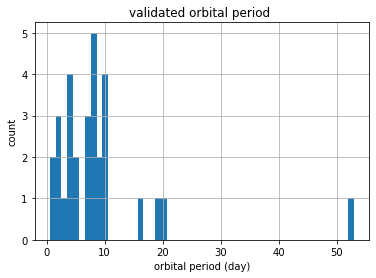

In [201]:
plt.title("validated orbital period ")
plt.hist(df_target["pl_orbper"], bins=52)
plt.grid(True)
plt.xlabel("orbital period (day)")
plt.ylabel("count")

In [109]:
for method in methods:
    print(f"number of images of {method}:", int(df_target[method].sum()))

number of images of biweight: 32
number of images of cosine: 28
number of images of GP_squared_exp: 27
number of images of GP_periodic_auto: 32


In [136]:
#extract SDE values from hdf5 files.
import deepdish as dd
methods = ["biweight", "cosine", "gp_Kernel_squared_exp", "gp_Kernel_periodic_auto"]

for idx, row in df_target.iterrows():
    tic = row['tic_id'].replace(' ', '')
    sector = str(row['sector'])
    pl_orb = float(row["pl_orbper"])
    pl_orb_upper = pl_orb + 2000 * row["pl_orbpererr1"]
    pl_orb_lower = pl_orb + 2000 * row["pl_orbpererr2"] #Note :  df_target["pl_orbpererr2"]  are negative
    
    if math.isnan(pl_orb):
        continue
        
    for method in methods:
        h5_file = f"../output/validated_candidates/tls_hdf5/{tic}_SECTOR{sector}_Method_{method}_{idx}.h5"

        try:
            h5d = dd.io.load(h5_file)

            power_list = h5d["power"]
            periods_list = h5d["periods"]

            mask = (periods_list > pl_orb_lower) & (periods_list < pl_orb_upper)
            SDE = max(power_list[mask])
            df_target.loc[idx, f"{method}_SDE"] = SDE
        except:
            pass

/home/kobayashi/miniconda3/envs/py3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [137]:
df_target

,tic_id,st_age,pl_trandur,pl_orbper,pl_orbpererr1,pl_orbpererr2,sector,biweight,cosine,GP_squared_exp,GP_periodic_auto,biweight_SDE,cosine_SDE,gp_Kernel_squared_exp_SDE,gp_Kernel_periodic_auto_SDE
0,TIC 166527623,0.017,4.82200,6.959503,0.000016,-0.000015,11,1.0,1.0,1.0,1.0,0.261192,0.496282,13.567166,6.478711
1,TIC 441420236,0.022,3.50000,8.463000,0.000002,-0.000002,01,1.0,1.0,1.0,1.0,-0.157121,0.959043,0.143198,2.148295
2,TIC 441420236,0.022,3.50000,8.463210,0.000040,-0.000040,01,1.0,1.0,1.0,1.0,-0.157121,1.692827,0.155655,4.532986
3,TIC 441420236,0.022,4.50000,18.859019,0.000016,-0.000016,01,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,TIC 460205581,0.035,1.95700,8.324876,0.000016,-0.000016,10,1.0,1.0,1.0,1.0,-0.007587,7.794174,12.442459,-0.264407
5,TIC 410214986,0.040,NaN,8.138700,0.000500,-0.000500,01,1.0,1.0,1.0,1.0,4.369573,9.379778,6.546198,3.165243
6,TIC 410214986,0.045,3.17640,8.138268,0.000011,-0.000011,01,1.0,1.0,1.0,1.0,0.288043,10.356623,-0.115326,3.165243
7,TIC 146520535,0.050,2.76100,4.326300,0.001100,-0.001100,32,1.0,1.0,1.0,1.0,6.838097,4.361567,6.659705,4.652996
8,TIC 146520535,0.050,3.72300,10.160500,0.005600,-0.005300,32,1.0,1.0,1.0,1.0,7.455475,9.332770,6.975240,6.703985
9,TIC 146520535,0.090,3.40320,4.324190,0.000030,-0.000030,32,1.0,1.0,1.0,1.0,5.822980,3.446360,6.659705,1.379750


In [138]:
df_target.to_csv("../output/validated_candidates/SDE_result.csv")

### Plot Difference

In [5]:
df_target = pd.read_csv("../output/validated_candidates/SDE_result.csv")
df_target.head()

,Unnamed: 0,tic_id,st_age,pl_trandur,pl_orbper,pl_orbpererr1,pl_orbpererr2,sector,biweight,cosine,GP_squared_exp,GP_periodic_auto,biweight_SDE,cosine_SDE,GP_squared_exp_SDE,GP_periodic_auto_SDE
0,0,TIC 166527623,0.017,4.822,6.959503,0.000016,-0.000015,11,1.0,1.0,1.0,1.0,0.261192,0.496282,13.567166,6.478711
1,1,TIC 441420236,0.022,3.500,8.463000,0.000002,-0.000002,1,1.0,1.0,1.0,1.0,-0.157121,0.959043,0.143198,2.148295
2,2,TIC 441420236,0.022,3.500,8.463210,0.000040,-0.000040,1,1.0,1.0,1.0,1.0,-0.157121,1.692827,0.155655,4.532986
3,3,TIC 441420236,0.022,4.500,18.859019,0.000016,-0.000016,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,4,TIC 460205581,0.035,1.957,8.324876,0.000016,-0.000016,10,1.0,1.0,1.0,1.0,-0.007587,7.794174,12.442459,-0.264407


In [53]:
def sde_comparison(method1, method2):
    idx = (df_target[method1]==1) & (df_target[method2]==1) 
    df_temp = df_target.loc[idx, [f"{method1}_SDE", f"{method2}_SDE"]].dropna()

    all_diff = []
    for _, row in df_temp.iterrows():
        cur_diff = []
        SDE_1 = row[f"{method1}_SDE"]
        SDE_2 = row[f"{method2}_SDE"]

        cur_diff.append(float(SDE_1 - SDE_2))
        all_diff.append(cur_diff)
    cnt_1 = sum([1 if x[0]<0 else 0 for x in all_diff ])
    cnt_2 = len(all_diff) - cnt_1
    plt.figure(figsize=(6, 4))
    plt.hist(all_diff, label=f"{method1}: {cnt_1}\n{method2}: {cnt_2}")
    plt.legend()
    plt.title(f"SDE Comparison: {method1} vs {method2}", fontsize=21)
    plt.xlabel(f"diff ({method1}_SDE - {method2}_SDE)", fontsize=18)
    plt.ylabel("count", fontsize=18)

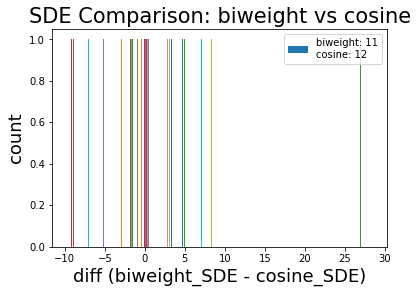

In [54]:
sde_comparison("biweight", "cosine")

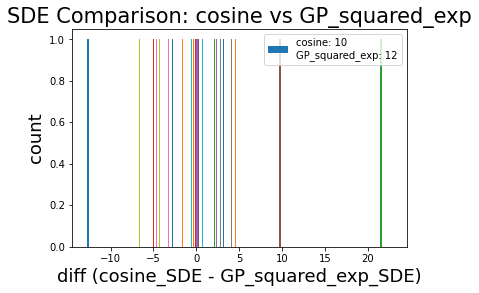

In [55]:
sde_comparison("cosine", "GP_squared_exp")

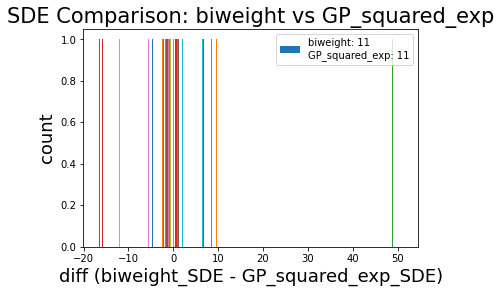

In [56]:
sde_comparison("biweight", "GP_squared_exp")

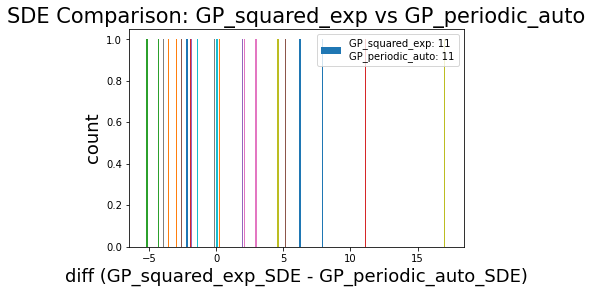

In [57]:
sde_comparison("GP_squared_exp", "GP_periodic_auto")

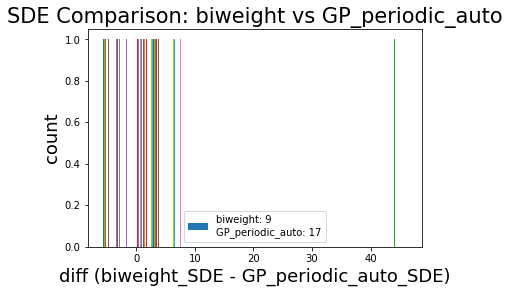

In [58]:
sde_comparison("biweight", "GP_periodic_auto")

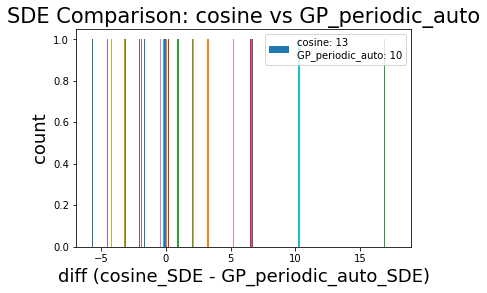

In [59]:
sde_comparison("cosine", "GP_periodic_auto")

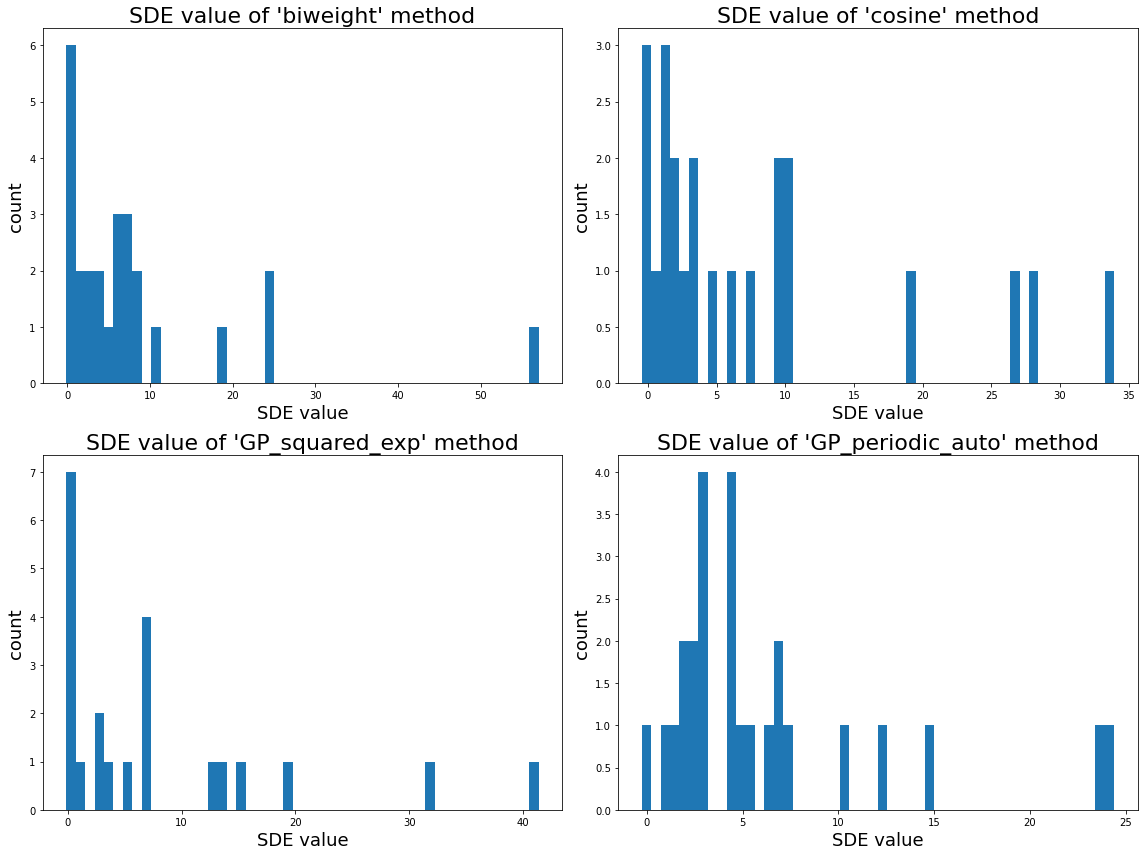

In [216]:
fig, axes = plt.subplots(2, 2, figsize=(16,12))
methods = [["biweight", "cosine"], ["GP_squared_exp", "GP_periodic_auto"]]
for i in range(2):
    for j in range(2):
        axes[i][j].set_title(f"SDE value of '{methods[i][j]}' method", fontsize=22)
        axes[i][j].hist(df_target[f"{methods[i][j]}_SDE"], bins=50)
        axes[i][j].set_xlabel("SDE value", fontsize=18)
        axes[i][j].set_ylabel("count", fontsize=18)
        
plt.tight_layout() 
plt.show()